In [23]:
import fitz
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Read all the images in the pdf created by camscanner
img_lst = []
doc = fitz.open("grade-8-mcq-answers.pdf")
for i in range(len(doc)):
    for img in doc.get_page_images(i):
        xref = img[0]
        pix = fitz.Pixmap(doc, xref)
        if pix.n >= 5:       # this is CMYK (not GRAY or RGB) so convert to RGB first
            pix = fitz.Pixmap(fitz.csRGB, pix)

        mode = "RGBA" if pix.alpha else "RGB"
        img = np.array(Image.frombytes(mode, [pix.width, pix.height], pix.samples))
        if img.shape[0] > 270: # this is to skip the camscanner logo which is of shape (260, 260, 3)
            img_lst.append(("p%s-%s.png" % (i, xref), img))

        pix = None

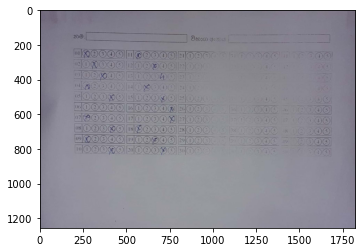

In [36]:
plt.imshow(img_lst[1][1])
plt.show()